# Koopman decomposition, a toy case: Duffing oscillator


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x(t)} = f(x(t)) \quad \text(1)
$$

where $\dot{x(t)} := {dx}/{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ (and space $\Omega$ if needed) the eq (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{t+dt} = x_t + dt\,f(x_t)$, which induces a $O(dt^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used. 


In [ ]:
def duffing(t, x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3 
    return dx

In [ ]:
tmax = 500    #time-horizon integration
niter = 5000  #number of time steps integration
Ninit = 60    #number of initial conditions

X0 = (np.random.rand(Ninit,2)-0.5)*4
t = np.linspace(0, tmax, niter)
Xt = np.zeros((X0.shape[0],X0.shape[1],niter))
for i in tqdm(range(X0.shape[0])):
    f = solve_ivp(duffing, [0,tmax], X0[i], method='RK45',t_eval=t)
    Xt[i,:] = f.y

100%|██████████| 60/60 [00:08<00:00,  6.97it/s]


The following plot shows trajectories for different initial conditions:

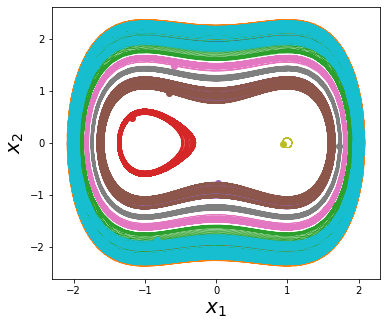

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(Xt[i,0,:], Xt[i,1,:],lw=0.5, color=cm(i))
    ax.plot(Xt[i,0,0], Xt[i,1,0],'o',lw=1.5, color=cm(i)) #initial condition
ax.set_xlabel('$x_1$', fontsize = 20)
ax.set_ylabel('$x_2$', fontsize = 20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{t+1} = \mathbf{F}(x_t)
$$

where $\mathbf{F}$ might be the flow map of the continuous dynamical system in eq (1) and $X = \{x_t | t = 1 \ldots N \}$ the time series of the system state.

$$
\mathbf{F}(x(t_0)) = x(t_0) + \int_{t_0}^{t_0+ t} f(x(\tau))d\tau 
$$

the Koopman theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ \mathbf{F}(x).
$$

This way, the non-linear dynamics of $x$, described by $\mathbf{F}$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions. 

For this purpose, given a time series $X = \{x_t | t = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_t)) - x_t  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_t ) - g_{\theta} (x_{t+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_t )\right) - x_{t+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png) 

In [ ]:
# arrange the dataset
from sklearn.model_selection import train_test_split
X = np.transpose(np.concatenate([Xt[i,:,:-1] for i in range(Xt.shape[0])], axis=1))
Y = np.transpose(np.concatenate([Xt[i,:,1:] for i in range(Xt.shape[0])], axis=1))

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000     # data per batch

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30       # dimension in Koopman space

In [ ]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)
        

In [ ]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a spectral radius $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem. 

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, making use of the Perron-Frobenius theorem.

In [ ]:
class KoopmanModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim

        self.weight = nn.Parameter(torch.randn(output_dim, output_dim))
        #self.weight = nn.Parameter(torch.abs(torch.randn(output_dim, output_dim))) #respect the condition k_ij > 0 

    ########## Test with different initializations ##########
    #self.reset_parameters()

    #def reset_parameters(self):
    #    torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(2))

    #self.A = nn.Parameter(torch.randn(output_dim, output_dim))
    #self.weight = nn.Parameter(symmetric(A))

    #def symmetric(X):
    #  return X.triu() + X.triu(1).transpose(-1, -2)
    ########################################################
    
    def forward(self, X):
        x, y = X.shape
        if y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        
        self.weight = nn.Parameter(torch.div(self.weight,self.weight.sum(0).max()))
        return torch.matmul(X,torch.transpose(self.weight,0,1))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
KPM = KoopmanModule(output_dim).to(device)
#print(AUTOENCODER)
KPM.weight.type()

'torch.cuda.DoubleTensor'

In [ ]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001)
opt_kpm = torch.optim.Adam(KPM.parameters(), lr=0.00001)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance;
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
return total_loss
```

In [ ]:
def LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred):
    criterion = nn.MSELoss()


    
    # Compute one part loss_l of the total loss
    # First deactivate gradient computation for irrelevant parts of the architecture
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = False
    loss_1 = criterion(X_recon, X_)   
    loss_3 = criterion(Y_pred, Y_) 

    # Restore the gradient computation
    for p in AUTOENCODER.encoder.parameters():
      p.requires_grad = True

    loss_2 = criterion(gY_pred, gY_)
    mu = gY_pred.mean(1)
    loss_4 = criterion(mu,torch.zeros_like(mu)) #mu regularization loss 
    sigma = torch.std(gY_pred,dim = 1, unbiased=False)
    loss_5 = criterion(sigma,torch.ones_like(sigma)) #sigma regularization loss

    total_loss = loss_1 + 10*loss_2 + 100*loss_3 + loss_4 + 0.01*loss_5
    return total_loss, loss_1, loss_2, loss_3, loss_4,loss_5

The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above.

In [ ]:
for epoch in range(100):
    AUTOENCODER.train() 
    KPM.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4, total_loss5 = 0, 0, 0, 0, 0
    for X_, Y_ in train_dataloader:
        X_, Y_ = X_.to(device), Y_.to(device)
        
        opt_aut.zero_grad()
        opt_kpm.zero_grad()
        
               
        # gX_ = observable(X_), gY_ = observable(Y_)
        gX_ = AUTOENCODER.encoder(X_)
        gY_ = AUTOENCODER.encoder(Y_)
        
        # X_recon = in_observable(observable(X_))
        X_recon = AUTOENCODER.decoder(gX_)
         
        # gY_pred = KPM*observable(X_)
        gY_pred = KPM(gX_)
        
        # Y_pred = inv_observable(KPM*observable(X_))
        Y_pred = AUTOENCODER.decoder(gY_pred)   
            
        output, output1, output2, output3,  output4, output5 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
        output.backward()
        opt_aut.step()
        opt_kpm.step()
    
        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
            total_loss1 += output1.item()/X_.size(0)/len(train_dataloader)
            total_loss2 += output2.item()/X_.size(0)/len(train_dataloader)
            total_loss3 += output3.item()/X_.size(0)/len(train_dataloader)
            total_loss4 += output4.item()/X_.size(0)/len(train_dataloader)
            total_loss5 += output5.item()/X_.size(0)/len(train_dataloader)
            
    if epoch%1 == 0:        
        print(epoch, "#"*10)
        print("Total loss : ", total_train_loss)
        print("Loss 1 : ", total_loss1)
        print("Loss 2 : ", total_loss2)
        print("Loss 3 : ", total_loss3)
        print("Loss 4 : ", total_loss4)
        print("Loss 5 : ", total_loss5)
    
    if epoch%10 == 0:
        AUTOENCODER.eval() 
        KPM.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_test_loss1, total_test_loss2, total_test_loss3, total_test_loss4, total_test_loss5 = 0, 0, 0, 0, 0
            for X_, Y_ in test_dataloader:
                X_, Y_ = X_.to(device), Y_.to(device)
    
                gX_ = AUTOENCODER.encoder(X_)
                gY_ = AUTOENCODER.encoder(Y_)
                X_recon = AUTOENCODER.decoder(gY_)
                gY_pred = KPM(gX_)
                Y_pred = AUTOENCODER.decoder(gY_pred)   
                    
                output, output1, output2, output3, output4, output5 = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
                total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
                total_test_loss1 += output1.item()/X_.size(0)/len(test_dataloader)
                total_test_loss2 += output2.item()/X_.size(0)/len(test_dataloader)
                total_test_loss3 += output3.item()/X_.size(0)/len(test_dataloader)
                total_test_loss4 += output4.item()/X_.size(0)/len(test_dataloader)
                total_test_loss5 += output5.item()/X_.size(0)/len(test_dataloader)
            
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print("Loss 1 : ", epoch, total_test_loss1)
            print("Loss 2 : ", epoch, total_test_loss2)
            print("Loss 3 : ", epoch, total_test_loss3)
            print("Loss 4 : ", epoch, total_test_loss4)
            print("Loss 5 : ", epoch, total_test_loss5)
            print('-'*106)
        

0 ##########
Total loss :  0.07506812103818161
Loss 1 :  0.0007518195786188803
Loss 2 :  2.1301265257925445e-05
Loss 3 :  0.0007409914953133643
Loss 4 :  2.953342171817197e-08
Loss 5 :  0.00041097422252850396
-------------------------------------------------- TEST --------------------------------------------------
0 0.07281838743668315
Loss 1 :  0 0.0007403351448144586
Loss 2 :  0 2.1375744564691444e-05
Loss 3 :  0 0.0007186019040274757
Loss 4 :  0 3.334319419419729e-08
Loss 5 :  0 0.00040711002800334
----------------------------------------------------------------------------------------------------------
1 ##########
Total loss :  0.06725449781185794
Loss 1 :  0.0007426854104877662
Loss 2 :  2.991360437818967e-05
Loss 3 :  0.0006620852127332598
Loss 4 :  2.6882416678841654e-07
Loss 5 :  0.00038862600954886207
2 ##########
Total loss :  0.04456810034781703
Loss 1 :  0.0006853940673514269
Loss 2 :  8.598967807326092e-05
Loss 3 :  0.00043017910801886836
Loss 4 :  1.7805919338011373e-06


#### Verification

**Question 3.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

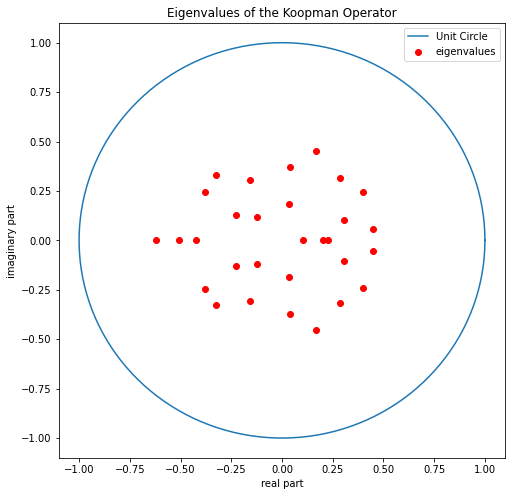

In [ ]:
#check Koopman stability
# Plot the eigen values of the Koopman operator against the unit circle

eigenvalues, eigenvectors = np.linalg.eig(KPM.weight.cpu().detach())

realpart = [x.real for x in eigenvalues]
imagpart = [x.imag for x in eigenvalues]
theta = np.linspace(0 , 2 * np.pi , 150) 
  
radius = 1
  
a = radius * np.cos( theta ) 
b = radius * np.sin( theta ) 

plt.figure(figsize = (8,8))    
plt.title("Eigenvalues of the Koopman Operator")
plt.plot(a, b, label = "Unit Circle") 
plt.scatter(realpart, imagpart, color='red', label = "eigenvalues")
plt.legend()
plt.xlabel("real part")
plt.ylabel("imaginary part")
plt.show()

In [ ]:
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = duffing(0,np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval() 
KPM.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] = (AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), KPM.weight.t())
                            ).detach().cpu().numpy() - [[xv[i,j],yv[i,j]]]).ravel()/(tmax/niter)
        

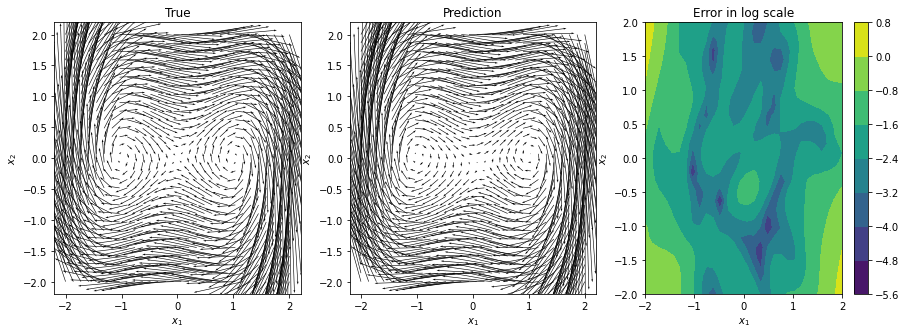

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_r$ as the observation of a state at time $t$, and $x_{r+1}$ the state at time $t+ \Delta t$, for $\Delta t \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_t)  = \lim_{\Delta t \rightarrow 0} \frac{\mathcal{K}g(x_t)- g(x_{t})}{\Delta t} = \frac{g \circ\mathbf{F} (x_t) -x_t}{\Delta t}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

As long as the system $f(x)$ is known, the three errors can be computed without data belonging to trajectories. 

In [ ]:
 # create dataset for continuous Koopman 
# with the same amount of points of the Discontinuous Koopman case
X0 = (np.random.rand(Ninit*(niter-1),2)-0.5)*4 
dX =np.zeros(X0.shape)
for i in tqdm(range(X0.shape[0])):
    dX[i,:] = duffing(0,X0[i,:])

100%|██████████| 299940/299940 [00:00<00:00, 434739.63it/s]


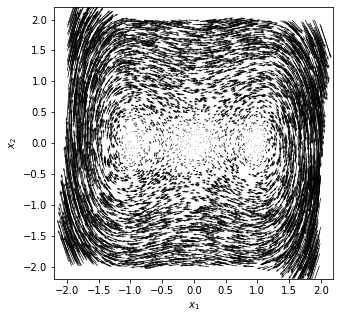

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.quiver(X0[::50,0],X0[::50,1], dX[::50,0]*0.2, dX[::50,1]*0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [ ]:
# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER) 
output_dim = 30       # dimension in Koopman space
batch_size = 2000     # data per batch

In [ ]:
X_train, X_test, Y_train, Y_test =  train_test_split(X0, dX, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [ ]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [ ]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))
        
    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [ ]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof. Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$. Minimizing the $\Vert \cdot \Vert_{\infty}$ norm, we can force just a few modes to be on the $\Re(\lambda) =0$ axes.



**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$.

In [ ]:
# custom nn.Linear to recover the Lie operator
class LieModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.nn.Parameter(torch.randn(output_dim, output_dim))
        self.gamma =  torch.nn.Parameter(torch.randn(output_dim))
        self.diagonal = torch.nn.Parameter(torch.diag(torch.abs(self.gamma)))
        self.reset_parameters()
        self.L = torch.nn.Parameter(self.weight - self.weight.t() - self.diagonal)

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
      

    def forward(self, X):
        x, y = X.shape
        if x != self.output_dim and y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        self.L = torch.nn.Parameter(self.weight - self.weight.t() - self.diagonal)
        
        #eigvals_real_part = torch.real(torch.linalg.eigvals(self.L))
        #eig_max = torch.max(eigvals_real_part)
        #eig_max.to(device)
        #if eig_max > 0 :
        #  self.L = nn.Parameter(self.L - torch.mul(eig_max, torch.eye(self.output_dim).to(device)))
        return torch.matmul(X,self.L), self.L 

In [ ]:
# start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
LIE = LieModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [ ]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
opt_lie = torch.optim.Adam(LIE.parameters(), lr=0.00001, weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.**

In [ ]:
def LOSS(X_, dX, gX, dgX, X_recon, dX_recon, jvp):
    criterion = nn.MSELoss()
    
    
    loss_1 = criterion(X_recon, X_)
    loss_2 = criterion(dgX, jvp)  
    mu = gX.mean(1)
    loss_4 = criterion(mu,torch.zeros_like(mu)) #mu regularization loss 
    sigma = torch.std(gX,dim = 1, unbiased=False)
    loss_5 = criterion(sigma,torch.ones_like(sigma)) #sigma regularization loss 
    
    # Compute one part loss_l of the total loss
    # First deactivate gradient computation for irrelevant parts of the architecture
    for p in AUTOENCODER.encoder.parameters():
        p.requires_grad = False
    
    loss_3 = criterion(dX_recon, dX)     

    # Restore the gradient computation
    for p in AUTOENCODER.encoder.parameters():
        p.requires_grad = True
        
        
    total_loss = loss_1 + 100*loss_2 + 100*loss_3 + 10*loss_4 + 10*loss_5
    return total_loss, loss_1, loss_2, loss_3, loss_4, loss_5

Since trajectories are not needed, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$ (see previous figure).

In [ ]:
for epoch in range(100):
    AUTOENCODER.train() 
    LIE.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4, total_loss5 = 0, 0, 0, 0, 0
    for X_, dX_ in train_dataloader:
        X_, dX_ = X_.to(device), dX_.to(device)

        opt_aut.zero_grad()
        opt_lie.zero_grad()
         
        # dgX = LIE*gX 
        # jvp = \nabla g * f(X_)
        (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
        X_recon = AUTOENCODER.decoder(gX)
         
        dgX, L = LIE(gX)
        dX_recon = AUTOENCODER.decoder(dgX)
            
        output, output1, output2, output3, output4, output5 = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
        output.backward()
        opt_aut.step()
        opt_lie.step()
        
        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
            total_loss1 += output1.item()/X_.size(0)/len(train_dataloader)
            total_loss2 += output2.item()/X_.size(0)/len(train_dataloader)
            total_loss3 += output3.item()/X_.size(0)/len(train_dataloader)
            total_loss4 += output4.item()/X_.size(0)/len(train_dataloader)
            total_loss5 += output5.item()/X_.size(0)/len(train_dataloader)
    
    if epoch%1 == 0:        
        print(epoch, "#"*10)
        print("Total loss : ", total_train_loss)
        print("Loss 1 : ", total_loss1)
        print("Loss 2 : ", total_loss2)
        print("Loss 3 : ", total_loss3)
        print("Loss 4 : ", total_loss4)
        print("Loss 5 : ", total_loss5)
    
    if epoch%10 == 0:
        AUTOENCODER.eval() 
        LIE.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_test_loss1, total_test_loss2, total_test_loss3, total_test_loss4, total_test_loss5 = 0, 0, 0, 0, 0
            for X_, dX_ in test_dataloader:
                X_, dX_ = X_.to(device), dX_.to(device)
    
                (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
                X_recon = AUTOENCODER.decoder(gX)
         
                dgX, L = LIE(gX)
                dX_recon = AUTOENCODER.decoder(dgX)
            
                output, output1, output2, output3, output4, output5 = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
                total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
                total_test_loss1 += output1.item()/X_.size(0)/len(test_dataloader)
                total_test_loss2 += output2.item()/X_.size(0)/len(test_dataloader)
                total_test_loss3 += output3.item()/X_.size(0)/len(test_dataloader)
                total_test_loss4 += output4.item()/X_.size(0)/len(test_dataloader)
                total_test_loss5 += output5.item()/X_.size(0)/len(test_dataloader)
            
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print("Loss 1 : ", epoch, total_test_loss1)
            print("Loss 2 : ", epoch, total_test_loss2)
            print("Loss 3 : ", epoch, total_test_loss3)
            print("Loss 4 : ", epoch, total_test_loss4)
            print("Loss 5 : ", epoch, total_test_loss5)
            print('-'*106)

0 ##########
Total loss :  0.14034641682708707
Loss 1 :  0.0006670241065421865
Loss 2 :  8.311770466752557e-06
Loss 3 :  0.0013497469312152483
Loss 4 :  6.852517169177393e-07
Loss 5 :  0.0003866670035175635
-------------------------------------------------- TEST --------------------------------------------------
0 0.13948523043972189
Loss 1 :  0 0.0006681010864677386
Loss 2 :  0 7.957675366115053e-06
Loss 3 :  0 0.00134178990295612
Loss 4 :  0 7.053813021703328e-07
Loss 5 :  0 0.00038353177080089045
----------------------------------------------------------------------------------------------------------
1 ##########
Total loss :  0.12889015184062158
Loss 1 :  0.0006664973712471311
Loss 2 :  1.888123702546115e-05
Loss 3 :  0.0012264962606361302
Loss 4 :  1.0737017925112032e-06
Loss 5 :  0.0003675167685290218
2 ##########
Total loss :  0.10087791129192834
Loss 1 :  0.0006783101730300706
Loss 2 :  5.130452276799641e-05
Loss 3 :  0.0009178764231486011
Loss 4 :  2.2197924554129995e-06
Loss

### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

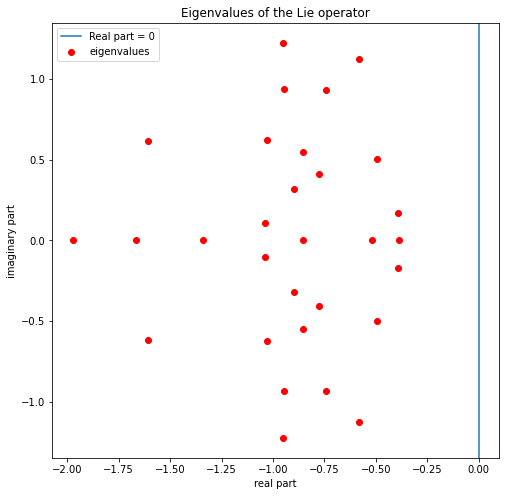

In [ ]:
#check LIE stability
eigenvalues, eigenvectors = np.linalg.eig(LIE.L.cpu().detach().numpy())
real_part = [x.real for x in eigenvalues]
imag_part = [x.imag for x in eigenvalues]

plt.figure(figsize = (8,8))   
plt.title("Eigenvalues of the Lie operator")
plt.axvline(x=0, label = "Real part = 0") 
plt.scatter(real_part,imag_part, color='red', label = "eigenvalues")
plt.legend()
plt.xlabel("real part")
plt.ylabel("imaginary part")
plt.show()

In [ ]:
def DUFFING(x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3 
    return dx

N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = DUFFING(np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval() 
LIE.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] =  AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), L)
                            ).detach().cpu().numpy()


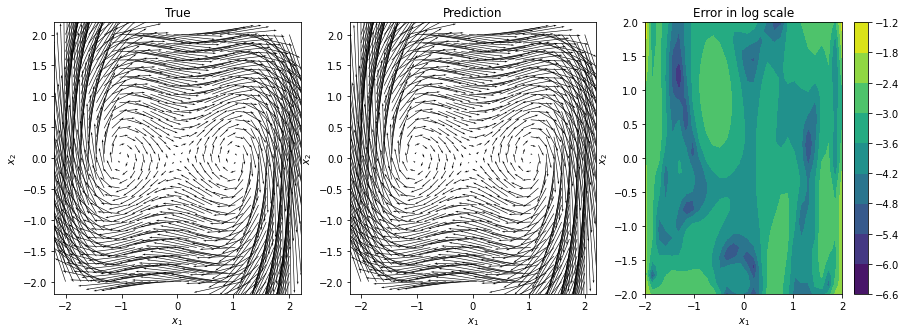

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

**Question 7.** : Compare and comment below the two approaches.

The first observation we can make is the importance of the initialization parameter. Indeed, for the Koopman operator, changing the initialization has a huge impact on the result. We tried to use the initialization to concentrate the eigenvalues of the trained operator close to 0 and also close to the unit circle but the results were less convincing than using a random initialization. Concerning the Lie operator, using Kaiming Uniform leads to better performance. Indeed, it is an initialization method that takes into account the non-linearity of activation functions **[6]**. This may explain the fact that it works well with the Lie Operator wich is used for nonlinear framework and less well with the Koopman Operator which is also linear but simplier defined (as only one matrix). 

Moreover, as stated, enforcing the spectral radius of the Koopman operator to be less than 1 improves the stability of the operator. This leads to a range of error (in logarithmic scale) between 0.8 and - 5.6 with largely uniform error around -2.4. However, by ignoring the assumption $k_{ij}>0$ in the Perron-Frobenius theorem, the stability is also provided and it leads us to better range of error even with less uniformity of the error that can be due to a relaxation of the constraints.

Most of the time, one can observe that the edges are the places where the error is the most important, this can be explained by the fact that it is at this place that the vector field is the most variable.

In general, the Lie operator gives better results than the Koopman operator. It seems that it is less sensitive to vector field variation and it reaches better prediction with bigger loss ($10^{-5}$ for the Lie op. against $10^{-8}$ for the Koopman op.). In addition, using regularization as in the VAE approach leads to a more uniform error. However, the sigma parameter has a huge influence on the results and using a loss with a high coefficient to better predict it with the Koopman Operator gives worse outcomes. The Lie operator is less sensitive and we can penalize more the prediction of the sigma parameter, which gives a better uniformity of the prediction error.

Concerning the balance of the loss functions, we have made sure to penalize (i.e. increase their coefficient) the loss functions that decreased the slowest and that at the end of 100 epochs were superior to the others. This led globally to better results even if another approach would have been more successful.

Following the hint, we disabled the encoder settings for prediction in phase space because the other predictions already took the encoder settings into account. This generally led to better results and more even error because it allowed the loss function in phase space to be reduced with less impact on the others. We did similar tests with the decoder settings turned off and with other loss combinations but the outcomes were less convincing.

Finally, our main objective was to minimize the maximum value of the error and, with the Lie operator, we achieved this with an error range between -1.2 and -6.6. Other tests showed minimum error values reaching -9.0 but a maximum error around 0, we considered these tests less convincing.

The Koopman operator has the advantage of linearity, allowing the conversion of a nonlinear dynamical system into a linear evolution equation, although at the cost of an infinite dimensionality of the operator **[3]**. There is then a representation issue. The modeling is indeed simpler but requires that the output_dim parameter be very large, which can be computationally expensive for the training.

Furthermore, one way to improve our model could be to better exploit the symmetry of the problem. Most of the time, dynamical systems exhibit some symmetries in their structure. We read in **[4]** that exploiting the symmetries in a system can improve the results. Here, the presence of symmetry is obvious and this seems to have an impact on the trained operators, for example, looking at their eigenvalues, one can see that they are also subject to symmetries. We exploited it by making the Koopman matrix symmetric. The results were quite similar to what we have without this symmetric initialization and all the eigenvalues were real. Finally, we decided to keep the normal initialization in order to have complex eigenvalues that retain more information than if they were only real.

Another improvement can be to use Riemannian metric and geodesic for the regularization of the latent space. Indeed, considering the structural geometry of the latent space (for instance by taking the variance as the metric volume element **[5]**) can lead to better regularization than only normal distribution consideration because the vector field is not globally uniform.


# References

[1] Bethany Lusch. J. Nathan Kutz. & Steven L. Brunton. **Deep learning for universal linear embeddings of nonlinear dynamics**, DOI: 10.1038/s41467-018-07210-0 

[2] Steven L. Brunton, Marko Budišić, Eurika Kaiser, J. Nathan Kutz. **Modern Koopman Theory for Dynamical Systems**, 2021.	arXiv:2102.12086

[3] Robert K. Niven, Laurent Cordier, Eurika Kaiser, Michael Schlegel, Bernd R. Noack. **Rethinking the Reynolds Transport Theorem, Liouville Equation, and Perron-Frobenius and Koopman Operators.** 2020. hal-02411477

[4] Salova A, Emenheiser J, Rupe A, Crutchfield JP, D'Souza RM. **Koopman operator and its approximations for systems with symmetries. Chaos.** 2019 Sep;29(9):093128. doi: 10.1063/1.5099091. PMID: 31575142.

[5] Clément Chadebec, Elina Thibeau-Sutre, Ninon Burgos, Stéphanie Allassonnière.  **Data Augmentation in High Dimensional Low Sample Size Setting Using a Geometry-Based Variational Autoencoder.** 2021.	arXiv:2105.00026 

[6] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. **Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification.** ICCV 2015